# Master script

* Take photo of background grid to extract lines.
* Let the Robot wander in the arena.
* Every x seconds a picture is taken 

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt 
import shapely
from shapely.geometry import LineString, Point, Polygon
import time
from scipy import spatial
import os

from functions import * # in functions.py file

# http://mathster.com/graphpaper/graphpaperjs/.

# Take background picture

Initializing HDMI camera link and loading camera intrinsincts to undistort image 

In [2]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_BUFFERSIZE, 0)
cam.set(cv2.CAP_PROP_FORMAT, cv2.CV_32F)
WIDTH = 1920
HEIGHT = 1080
cam.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
[matrix,distortion,newcameramtx] = np.load("../camera-calibration/intrinsics.npy",allow_pickle=True)

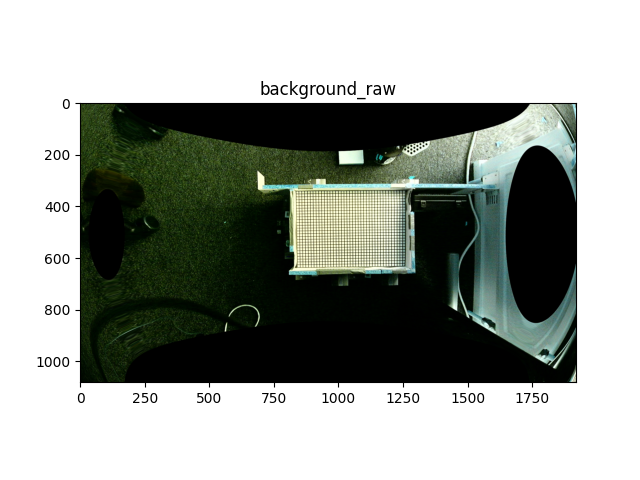

In [21]:
%matplotlib ipympl
avgiter=5
# take_pic(cam,avgiter)
background_raw = take_pic_undist(cam,avgiter,matrix,distortion,newcameramtx)
# nb_show("raw background",cv2.cvtColor(background_raw, cv2.COLOR_RGB2BGR))
cv2.imwrite('./content/background.jpg',background_raw)
nb_show("background_raw",background_raw)

Here you have to crop manually the image to fit perfectly the grid 

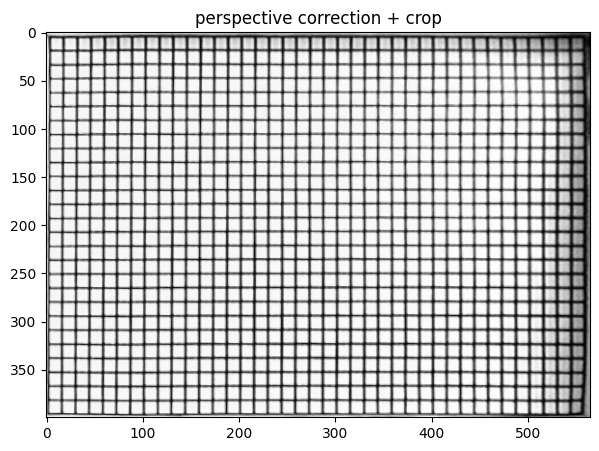

In [28]:
%matplotlib inline
src = np.float32([(833,337),(840,639),(1264,633),(1264,334)]) # top right, bottom right, bottom left, top left 
h = 400
w = 400 * math.sqrt(2)
dst = np.float32([[0,0],[0,h],[w,h],[w,0]])
M = cv2.getPerspectiveTransform(src, dst)


paper_sheet = np.zeros((int(w),int(h)), dtype=np.uint8)
background = cv2.warpPerspective(background_raw, M, paper_sheet.shape)
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

nb_show("perspective correction + crop",background)

GRID SHAPE : (40, 28, 2)


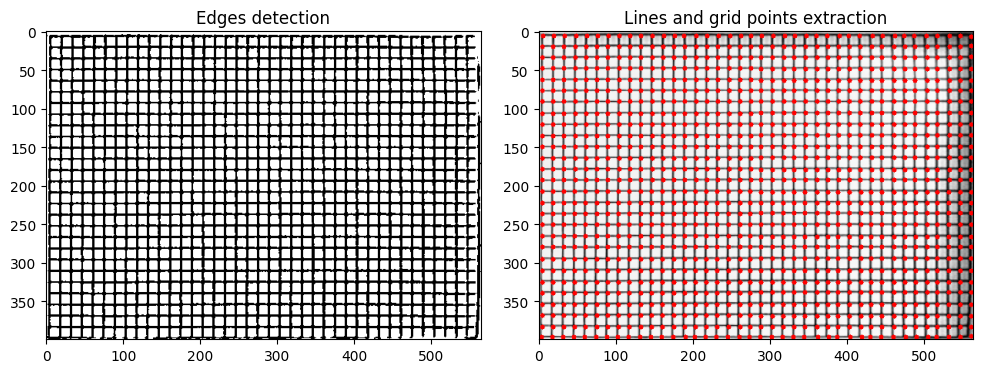

In [54]:
%matplotlib inline

edges = processing_background(background)

# Create HoughBundler instance to process lines given by cv2.HoughLinesP()
bundler = HoughBundler(min_distance=5,min_angle=5)
#background_processed = bundler.preprocessing(background)
lines_bulk = cv2.HoughLinesP(cv2.bitwise_not(edges),rho = 1,theta = 1*np.pi/180,threshold = 140,minLineLength = 100,maxLineGap = 50)
lines = bundler.process_lines(lines_bulk)

# Convert processed lines to a point matrix
points_matrix_unsorted = lines_to_grid(lines)
i = 0
points_matrix_sorted = points_matrix_unsorted
for row in points_matrix_unsorted:
    prod = row[row[:, 0].argsort()]
    points_matrix_sorted[i][:] = prod
    i = i+1

points_matrix = np.transpose(points_matrix_sorted,(1,0,2))

img_out_lines = cv2.cvtColor(background.copy(),cv2.COLOR_GRAY2RGB)
for line in lines_bulk:
    cv2.line(img_out_lines,(line[0][0],line[0][1]),(line[0][2],line[0][3]),(0,0,255),1)

img_out_1 = cv2.cvtColor(background.copy(),cv2.COLOR_GRAY2RGB)
for line in lines:
    cv2.line(img_out_1,(line[0][0],line[0][1]),(line[0][2],line[0][3]),(0,0,255),2)
for i in range(points_matrix.shape[0]):
  for j in range(points_matrix.shape[1]):
    cv2.circle(img_out_1, points_matrix[i][j][:] , radius=3, color=(255, 0, 0), thickness=-1)

print("GRID SHAPE :",points_matrix.shape)
nb_show_n([ "Edges detection", "Lines and grid points extraction"],[edges, img_out_1])

Background image has been processed, and grid points have been extracted. 

# Actual measuring loop :

Now, turn the spiderino ON. Place it on the grid. Plug ESP8266 receiver to PC and listen on serial monitor via serial_read.ipnyb
* At every iteration of the loop, the script tries to locate green and red LEDs to compute Spiderino position and angle.
* Then, as the boundaries positions are known, theoretical distances to the wall seen by the sensors are computed.
* Finally, computed values are stored with measured values in a csv file.

In [44]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt 
import shapely
from shapely.geometry import LineString, Point, Polygon
import time
from scipy import spatial
import os


## GENERAL FUNCTIONS :

def nb_show(title, img):
    plt.imshow(img, cmap="gray"), plt.title(title)
    # plt.xticks([]),plt.yticks([])
    plt.show()

def nb_show_n(title_list, img_list):
   n = len(title_list)
   m = len(img_list)
   if n > 1  and m == m :
      plt.rcParams['figure.figsize'] = [n*5, 5]
      fig, ax = plt.subplots(1, n)
      plt.tight_layout()
      r = 0
      for axis in ax :
         axis.title.set_text(title_list[r])
         axis.imshow(img_list[r], cmap="gray")
         r=r+1
   plt.show()

def take_pic(cam_object, niter) :
   avg = []
   for i in range(niter):
      time.sleep(0.1)
      if cam_object.isOpened(): 
         ret, a = cam_object.read()
         
         avg.append(a)
         if ret:
            pass 
         else:
            print("frame not captured")
      else:
         print("cannot open camera")
      
      if i == 0:
         dst = avg[i]
      else:
         alpha = 1.0/(i + 1)
         beta = 1.0 - alpha
         dst = cv2.addWeighted(avg[i], alpha, dst, beta, 0.0)
   avg_pic = dst
   return avg_pic

def take_pic_undist(cam_object, niter, matrix,distortion,newcameramtx):
  src = take_pic(cam_object, niter)
  dst = cv2.undistort(src, matrix,distortion, None, newcameramtx)
  # crop the image
  # x,y,w,h = roi
  # dst = dst[y:y+h, x:x+w]
  return dst

## BACKGROUND PROCESSING FUNCTIONS :

def get_bounding_box(img) :
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(img_gray,(5,5),0)
  # ret2,th2 = cv2.threshold(blur,100,120,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

  edges = cv2.Canny(th2,150,160,L2gradient = True)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  c = max(contours, key = cv2.contourArea)
  x,y,w,h = cv2.boundingRect(c)
  # cpy = edges.copy()
  # cv2.rectangle(cpy, (x, y), (x + w, y + h), (255,0,0), 4)
  # nb_show("background cropped",cpy)
  return cv2.boundingRect(c)

def crop(img_in, box):
  x,y,w,h = box
  img_out = img_in[y:y+h,x:x+w]
  return img_out

def processing_background(img_in):
    blur = cv2.GaussianBlur(img_in,(3,3),0)
    # 3x3 array for edge detection
    sobel_y = np.array([[ -1, -2, -1], 
                    [ 0, 0, 0], 
                    [ 1, 2, 1]])

    ## TODO: Create and apply a Sobel x operator
    sobel_x = np.array([[ -1, 0, 1], 
                    [ -2, 0, 2], 
                    [ -1, 0, 1]])

    edge_detection = np.array([[ 0.0, -1, 0], 
                            [ -1, 4, -1], 
                            [ 0, -1, 0]])

    kernel3 = np.array([[0, -1,  0],
                    [-1,  5, -1],
                        [0, -1,  0]])
    # Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  https://alyxion.github.io/Udacity_IntroToSelfDrivingCarsNd/8_1_Intro_Mini_Projects/41_Finding%20Edges%20and%20Custom%20Kernels.html
    sobely = cv2.filter2D(blur, -1, sobel_y)
    # Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
    sobelx = cv2.filter2D(blur, -1, sobel_x)
    sobelxy = cv2.bitwise_not(cv2.addWeighted(sobely, 0.5, sobelx, 0.5, 0))
    # Otsu's thresholding after Gaussian filtering
    blurred = cv2.GaussianBlur(sobelxy,(3,3),0)
    ret3,img_out = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    return img_out

## LINE + GRID FINDING FUNCTIONS :

class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)


    def denoise(self, noisy):
      kernel1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]], np.uint8)
      kernel2 = np.array([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]], np.uint8)
      hitormiss1 = cv2.morphologyEx(noisy, cv2.MORPH_ERODE, kernel1)
      hitormiss2 = cv2.morphologyEx(cv2.bitwise_not(noisy), cv2.MORPH_ERODE, kernel2)
      hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2)
      hitormiss_comp = cv2.bitwise_not(hitormiss) 
      clean = cv2.bitwise_and(noisy, noisy, mask=hitormiss_comp)
      return clean

    def preprocessing(self, img_in):
      blur = cv2.GaussianBlur(img_in,(3,3),0)
      threshold = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,2)
      threshold = cv2.bitwise_not(threshold)
      threshold = self.denoise(threshold)
      kernel = np.ones((3,3))
      img_out = cv2.dilate(threshold, kernel, iterations=1)
      return img_out

def linesSort(lines):
  lines_v = []
  lines_h = []
  delta_x = 50
  delta_y = 50

  for line in lines:
      x1, y1, x2, y2 = line[0]

      if x2 > x1 - delta_x and x2 < x1 + delta_x :
        lines_h.append(line)

      if y2 > y1 - delta_y and y2 < y1 + delta_y :
        lines_v.append(line)
  
  return lines_h,lines_v

def get_equation(p1, p2):
  A = (p1[1] - p2[1])
  B = (p2[0] - p1[0])
  C = (p1[0]*p2[1] - p2[0]*p1[1])
  return A, B, -C

def intersection(L1, L2):
  D  = L1[0] * L2[1] - L1[1] * L2[0]
  Dx = L1[2] * L2[1] - L1[1] * L2[2]
  Dy = L1[0] * L2[2] - L1[2] * L2[0]
  if D != 0:
    x = Dx / D
    y = Dy / D
    return int(x),int(y)
  else:
    return False

def closest_node(node, nodes):
  nodes = np.asarray(nodes)
  deltas = nodes - node
  dist_2 = np.einsum('ij,ij->i', deltas, deltas)
  return np.argmin(dist_2)

def lines_to_grid (lines):
  lines_h,lines_v = linesSort(lines)
  grid_list = []
  for lineh in lines_h :
    for linev in lines_v :
      L1 = get_equation([lineh[0][0],lineh[0][1]] ,[lineh[0][2],lineh[0][3]])
      L2 = get_equation([linev[0][0],linev[0][1]] ,[linev[0][2],linev[0][3]])
      R = intersection(L1, L2)
      # print(R)
      grid_list.append(R)
  nodes = np.array(sorted(grid_list , key=lambda k: [k[1], k[0]]))
  reshaped = np.reshape(nodes,(len(lines_v),len(lines_h),2)).astype(int)
  return reshaped

def lines_to_grid_2 (lines):
    lines_h,lines_v = linesSort(lines)
    grid_list = []
    for lineh in lines_h :
        for linev in lines_v :
            L1 = get_equation([lineh[0][0],lineh[0][1]] ,[lineh[0][2],lineh[0][3]])
            L2 = get_equation([linev[0][0],linev[0][1]] ,[linev[0][2],linev[0][3]])
            R = intersection(L1, L2)
            # print(R)
            grid_list.append(R)
    # nodes = np.array(sorted(grid_list , key=lambda k: [k[0], k[1]]))
    # reshaped = np.reshape(nodes,(len(lines_h),len(lines_v),2)).astype(int)
    nodes = grid_list
    reshaped = nodes
#   reshaped = np.reshape(nodes,(len(lines_h),len(lines_v),2)).astype(int)
    return reshaped

## CENTROID FINDING FUNCTION :

def get_centroids(img) :
    cXlist=[]
    cYlist=[]
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
    for c in sorted_contours:
        # calculate moments for each contour
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cXlist.append(cX)
            cYlist.append(cY)
        else:
            pass # do nothing, centroid value is not usable
    return cXlist,cYlist

## GENERAL GEOMETRIC OPERATIONS FUNCTIONS :

def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return round(np.degrees(angle),2)  

def get_point_angle(start, angle):
  angle = -angle
  end = Point(int(start.x + 2000 * math.cos(math.radians(angle))),
            int(start.y + 2000 * math.sin(math.radians(angle))))
  return end

## CLASSES FOR STORING DATAS (POSITION OF ROBOT, GRID, SENSORS ORIENTATIONS ... ) :

class Grid:
  def __init__(self, points_matrix):
    self.points_matrix = np.asarray(points_matrix)
    self.x_max = self.points_matrix.shape[0]-1
    self.y_max = self.points_matrix.shape[1]-1
    self.boundaries = self.calculate_boundaries()

  def find_closest_node(self, object):
    # deltas = self.points_matrix.reshape((-1,2)) - object
    deltas = self.points_matrix.reshape((-1,2)) - object
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    min_dist = np.argmin(dist_2)
    xnode = int(min_dist/(self.points_matrix.shape[1]))
    ynode = min_dist - xnode*(self.points_matrix.shape[1])
    return xnode,ynode

  def find_closest_node_2(self, node):
    smallest_dist = 1000
    for i in range(self.points_matrix.shape[0]):
      for j in range(self.points_matrix.shape[1]):
        dist = np.linalg.norm(self.points_matrix[i][j]-node)
        if (dist < smallest_dist):
          smallest_dist = dist
          nbi = i
          nbj = j
    return nbi,nbj

  def calculate_boundaries(self):
    return LineString([Point((0,0)), Point(self.x_max, 0), Point(self.x_max, self.y_max), Point(0, self.y_max), Point(0, 0)])

class Sensor:
  def __init__(self, pos, angle):
    self.pos = pos
    # self.measure = 0
    self.angle = angle 
    self.ray = 0

  # def setMeasure(self,meas):
  #   self.measure = meas

  def setRay(self,ray):
    self.ray = ray

class Robot:
  def __init__(self, pos, theta, n_sensors):
    self.pos = pos
    self.theta = theta
    self.n_sensors = n_sensors
    self.sensors_array = []
    for n in range(self.n_sensors):
      sens = Sensor(self.pos,(self.theta+n*360/self.n_sensors))
      self.sensors_array.append(sens)

  def calculate_distances(self, grid):
    hits = []
    distances = []
    for sensor in self.sensors_array:
      ray_end = get_point_angle(self.pos , sensor.angle)
      # print(self.pos)
      # print(ray_end)
      ray_infinite = LineString([self.pos,ray_end])
      hit = grid.boundaries.intersection(ray_infinite)
      ray = LineString([self.pos,hit])

      sensor.setRay(ray)
      distance = sensor.ray.length
      
import pandas as pd

# Code from :
# https://stackoverflow.com/questions/10948589
# and https://stackoverflow.com/questions/30331944

def red_blob_extract(frame) :
  # RED BLOB EXTRACTION
  kernel = np.ones((2,2))
  result = frame.copy()
  image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  lower = np.array([0,40,120])
  upper = np.array([10,255,255])
  mask = cv2.inRange(image, lower, upper)
  result = cv2.bitwise_and(result, result, mask=mask)
  h, s, red_blobs = cv2.split(result)
  ret2,red_blobs_th = cv2.threshold(red_blobs,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  red_blobs_erode = red_blobs_th
  red_blobs_dilate = cv2.dilate(red_blobs_erode,kernel,iterations=2)
  cXlistR,cYlistR = get_centroids(red_blobs_dilate)
  return cXlistR,cYlistR,red_blobs_th,red_blobs_dilate

def green_blob_extract(frame) :
  # GREEN BLOB EXTRACTION
  kernel = np.ones((2,2))
  result = frame.copy()
  image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  lower = np.array([45,150,60])
  upper = np.array([65,255,255])
  mask = cv2.inRange(image, lower, upper)
  result = cv2.bitwise_and(result, result, mask=mask)
  h, s, green_blobs = cv2.split(result)
  ret2,green_blobs_th = cv2.threshold(green_blobs,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  green_blobs_erode = green_blobs_th
  green_blobs_dilate = cv2.dilate(green_blobs_erode,kernel,iterations=2)
  cXlistG,cYlistG = get_centroids(green_blobs_dilate)
  return cXlistG,cYlistG,green_blobs_th,green_blobs_dilate

def extract_points(frame,points_matrix) :
  cXlistR,cYlistR,th_r,dil_r = red_blob_extract(frame)
  cXlistG,cYlistG,th_g,dil_g  = green_blob_extract(frame)

  imge = np.copy(frame)
  if (len(cXlistR) == 0) or (len(cXlistG) == 0) :
      print("Stuggling to find red or green led, check this :")
      # nb_show_n(["Frame taken","GREEN extract thresholded", "RED extract thresholded"], [imge,th_g, th_r])
      # nb_show_n(["Frame taken","GREEN extract after erosion", "RED extract after erosion"], [imge,green_blobs_erode, red_blobs_erode])
      return 0
  else :
      # print("Succesfully found centroids of red AND green leds.")
      red_x, red_y = (cXlistR[0], cYlistR[0])
      green_x, green_y = (cXlistG[0],cYlistG[0])
      red_led = Point(red_x, red_y)
      green_led = Point(green_x, green_y)

      cv2.circle(imge, (red_x, red_y), 5, (255, 0, 0), -1)
      cv2.circle(imge, (green_x, green_y), 5, (0, 255,0), -1)

      for i in range(points_matrix.shape[0]):
        for j in range(points_matrix.shape[1]):
          cv2.circle(imge, points_matrix[i][j][:] , radius=2, color=(0,0,255), thickness=-1)
      nb_show_n(["Green color extracts", "RED color extracts", "Green and Red patches locations"], [dil_g, dil_r, imge])
      return red_led,green_led
 
def angle_leds(red_led, green_led,lines):
  angle_uncal = azimuth(green_led,red_led)

  lines_h,lines_v = linesSort(lines)
  a = []
  for linev in lines_v :
      # print(lineh)
      P1 = Point(linev[0][0], linev[0][1])
      P2 = Point(linev[0][2], linev[0][3])
      a.append(azimuth(P1,P2))

  avg = round(np.average(a),2)
  # angle_cal = angle_uncal + avg
  angle_cal = angle_uncal
  # print("angle_uncal" + str(angle_uncal) )
  # print("avg" + str(avg) )
  return angle_cal

def rays_calculations(frame, grid_cm_ratio, sensor_center_distance, points_matrix, lines) :
  red_led, green_led = extract_points(frame, points_matrix)

  spiderino_centroid = green_led
  angle_cal = angle_leds(red_led, green_led, lines)
  # Create a Grid instance
  grid = Grid(points_matrix)

  nsensors = 4
  theta = angle_cal + 22.5
  print(angle_cal)
  print(theta)
  x_snap,y_snap = grid.find_closest_node(spiderino_centroid)
  spiderino = Robot(Point(x_snap,y_snap),theta,nsensors)

  # Calculate distances of sensors to boundaries
  spiderino.calculate_distances(grid)

  real_rays = []
  for each in spiderino.sensors_array :
    real_val = round(grid_cm_ratio * each.ray.length - sensor_center_distance,2)
    real_rays.append(real_val)

  return spiderino, grid, real_rays, spiderino_centroid

def add_data_to_csv(features_path, labels_vect, output_path) :

  #  Creating a DF from calculated values
  cam_data = []
  for each in labels_vect :
    cam_data.append([each])
  cam_df = pd.DataFrame(np.array(cam_data).T,columns = ["IR0_cam", "IR1_cam", "IR2_cam", "IR3_cam"])

  # Creating a DataFrame from .csv file
  meas_df = pd.read_csv(features_path, sep=",")
  
  #  Creating merge DataFrame by concatenation and append it to data file
  merge = pd.concat([meas_df,cam_df], axis=1)
  path = output_path
  merge.to_csv(path,index=False, mode='a', header=not os.path.exists(path))

def add_data_to_csv_from_vect(features_vect, labels_vect, output_path) :

  #  Creating a DF from calculated values
  cam_data = []
  for each in labels_vect :
    cam_data.append([each])
  labels_df = pd.DataFrame(np.array(cam_data).T,columns = ["IR0_cam", "IR1_cam", "IR2_cam", "IR3_cam"])

  #  Creating a DF from measured values
  meas_data = []
  for each in features_vect :
    meas_data.append([each])
  features_df = pd.DataFrame(np.array(meas_data).T,columns = ["IR0_meas", "IR1_meas", "IR2_meas", "IR3_meas"])
  
  #  Creating merge DataFrame by concatenation and append it to data file
  merge = pd.concat([labels_df,features_df], axis=1)
  path = output_path
  merge.to_csv(path,index=False, mode='a', header=not os.path.exists(path))

def plotos(spiderino_centroid, spiderino, grid, grid_cm_ratio,real_rays,sensor_center_distance) :
    # print("SPIDERINO :")
    # print(" - Pixel Position (x,y) =",spiderino_centroid)
    # print(" - Grid Position (x,y) =",spiderino.pos)
    # print(" - Angle (deg) =",spiderino.theta)

    # print("\nREAL RAYS LENGTHS (cm) :")
    # i=0
    # for each in spiderino.sensors_array :
    #     print(" - Ray length = ", grid_cm_ratio, " x ", round(each.ray.length,2) ," - ", sensor_center_distance," = ", real_rays[i] , " cm ")
    #     i=i+1

    # SHOW VISUALIZER
    # print("\nGEOMETRIC REPRESENTATION :")
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(*grid.boundaries.xy, label="Boundaries ( "+ str(grid.x_max) +"x"+ str(grid.y_max) +" )")
    plt.plot(*spiderino.pos.xy, marker="o", markersize=80, markeredgecolor="black", markerfacecolor="none", markeredgewidth=3)
    i=0
    for sensor in spiderino.sensors_array :
        plt.plot(*sensor.ray.xy, label="Ray Length = " + str(round((sensor.ray.length),2)) +" (" +str(real_rays[i])+" cm)")
        i=i+1
    leg = plt.legend(loc='upper right')
    ax.set_xticks(np.arange(0,grid.x_max+1))

    ax.set_yticks(np.arange(0,grid.y_max+1))
    # ax.invert_yaxis()
    plt.gca().invert_yaxis()
    plt.grid(True)
    ax.title.set_text("Geometric Model of Spiderino in a Grid")
    plt.show()



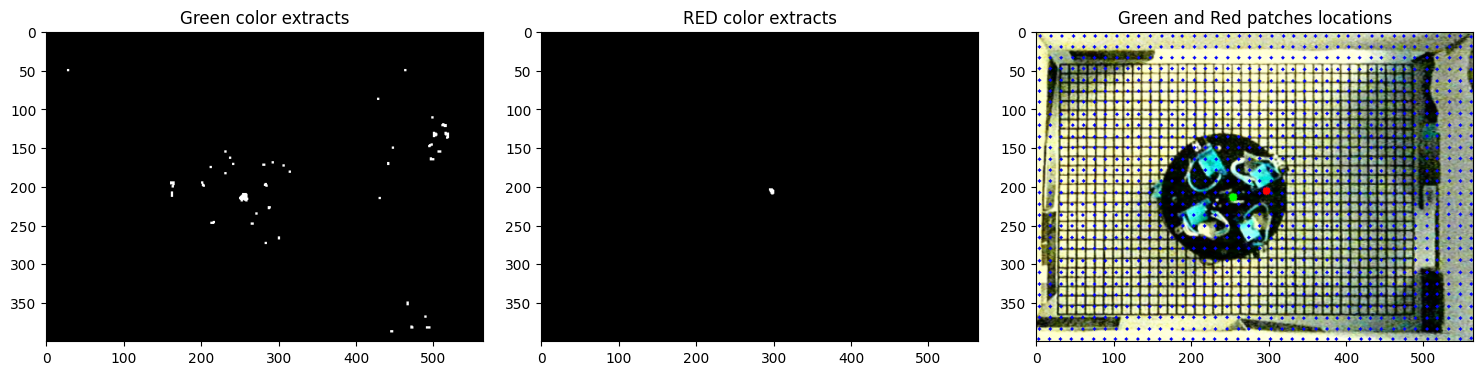

100.54
123.04
OK


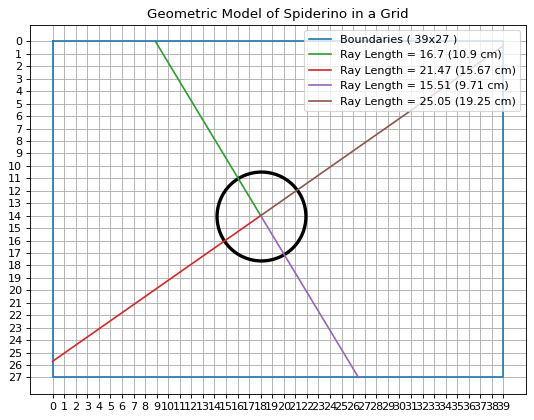

SystemExit: 0

In [45]:
import serial
from IPython.display import clear_output
import time
import sys, signal

def signal_handler(signal, frame):
    sys.exit(0)

header = ["IR0_meas", "IR1_meas", "IR2_meas", "IR3_meas"]


grid_cm_ratio = 1 # 1 unit on grid = 3cm
sensor_center_distance = 5.8 # sensors are placed {sensor_placement} cm from center
avgiter=1
# fig = plt.figure(figsize=(8, 6), dpi=80)


fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)



try :
    while True :
        try : 
            signal.signal(signal.SIGINT, signal_handler)

            frame_raw = take_pic_undist(cam,1,matrix,distortion,newcameramtx)
            frame_color = cv2.warpPerspective(frame_raw, M, paper_sheet.shape)
            cv2.imwrite('./content/frame.jpg',frame_color)
            # try :
            #     spiderino, grid, real_rays, spiderino_centroid = rays_calculations(frame_color, grid_cm_ratio ,sensor_center_distance, points_matrix, lines)
            # except :
            #     print("rays_calculations_pb")
            #     break
            spiderino, grid, real_rays, spiderino_centroid = rays_calculations(frame_color, grid_cm_ratio ,sensor_center_distance, points_matrix, lines)
            
            # add_data_to_csv(features_path = "./content/measures.csv",labels_vect = real_rays,output_path = './content/merge-0312.csv')
            print("OK")
            plotos(spiderino_centroid, spiderino, grid, grid_cm_ratio,real_rays,sensor_center_distance)


            # ax.cla()
            # plt.plot(*grid.boundaries.xy, label="Boundaries ( "+ str(grid.x_max) +"x"+ str(grid.y_max) +" )")
            # plt.plot(*spiderino.pos.xy, marker="o", markersize=80, markeredgecolor="black", markerfacecolor="none", markeredgewidth=3)
            # i=0
            # for sensor in spiderino.sensors_array :
            #     plt.plot(*sensor.ray.xy, label="Ray Length = " + str(round((sensor.ray.length),2)) +" (" +str(real_rays[i])+" cm)")
            #     i=i+1
            # leg = plt.legend()
            # ax.set_xticks(np.arange(0,grid.x_max+1))
            # ax.set_yticks(np.arange(0,grid.y_max+1))
            # plt.gca().invert_yaxis()
            # plt.grid(True)
            # ax.title.set_text("Geometric Model of Spiderino in a Grid")
            # # ax.invert_yaxis()
            # display(fig)
            # # clear_output(wait = True)


            time.sleep(5)
            clear_output(wait=True)
        except KeyboardInterrupt:
            print("interrupt")
            sys.exit(0)
except KeyboardInterrupt:
    print("interrupt")
    sys.exit(0)

